<a href="https://colab.research.google.com/github/pushtii07/tesla-streamlit-app/blob/main/Tesla_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tesla Stock Price Prediction**

**Introduction**

Stock price prediction has long been a challenging problem in the field of data science and finance. Prices are influenced by a wide range of factors including market sentiment, company performance, macroeconomic indicators, and unexpected events. Despite this complexity, forecasting models can provide valuable insights into short‑term and long‑term trends, helping investors and analysts make more informed decisions.

In this project, we focus on predicting Tesla’s stock prices using deep learning techniques.  The goal is to build, train, and evaluate two different recurrent neural network architectures:


*    SimpleRNN — a basic recurrent model that captures short‑term dependencies.

*    LSTM (Long Short‑Term Memory) — a more advanced recurrent model designed to handle longer dependencies and reduce issues like vanishing gradients.


We'll evaluate these models across multiple forecast horizons: 1‑day, 5‑day, and 10‑day ahead predictions. By comparing their performance, we aim to understand how well each model captures stock price trends, how prediction accuracy changes with horizon length, and what limitations exist in applying deep learning to financial forecasting.

GitHub Link: https://github.com/pushtii07/tesla-streamlit-app

Project Link: https://tesla-app-app-jv7uthevt2ec5xapdnezd4.streamlit.app/

Importing Libraries and accessing the dataset


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Data Preparation**

The dataset used in this project consists of historical Tesla stock prices, including attributes such as Open, High, Low, Close, Adjusted Close, and Volume. Since stock prices are continuous and vary widely in scale, preprocessing was essential to ensure stable training of deep learning models.     
**Data Collection:**

  The dataset was obtained in CSV format containing daily Tesla stock prices.

  The focus was primarily on the Adjusted Close price, which reflects the true market value.

**Data Preprocessing:**

  Scaling:

   All values are normalized using MinMaxScaler to bring them into the range [0,1].

   This step ensures that the neural networks train efficiently without being biased by large numerical values.

**Sequence Creation:**

  Time series forecasting requires converting raw data into sequences.

  Sliding windows of past values are created to predict future prices.

  Three horizons are prepared:

  1‑day ahead prediction

  5‑day ahead prediction

  10‑day ahead prediction

 **Train/Test Split:**

  The dataset is split into training and test sets to evaluate model performance.

  Approximately 80% of the data is used for training, while 20% is reserved for testing.

In [20]:
df=pd.read_csv("/content/TSLA.csv")
df.head()
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...,...
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300


In [21]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [22]:
df['Date']=pd.to_datetime(df['Date'])
df=df.sort_values('Date').set_index('Date')

In [23]:
df.columns=[c.strip() for c in df.columns]

In [24]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [25]:
target_col="Adj Close"

In [26]:
df.isnull().any()
df.duplicated().any()

np.False_

In time series, if there were missing values, we wouldn’t drop rows because that breaks the sequence.

Instead, we would use forward-fill(ffill) or backward-fill(bfill) to keep the timeline continuous.

as if Tesla didn’t trade on a day and the price was missing, forward-fill would copy the last known price forward.

In [27]:
df[target_col]=df[target_col].ffill().bfill()

**Scaling and Sequence Creation**

Neural networks train better when inputs are normalized (scaled between 0 and 1).

Stock prices are sequential, so we need to create windows of past days (e.g., last 60 days) to predict the next day(s).

three sets will be prepared: 1-day ahead, 5-day ahead, and 10-day ahead.

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaled=scaler.fit_transform(df[[target_col]].values)
#normalizing between 0 an 1

Creating sequences(windows of past days)

We’ll use a lookback window to predict the next price
Time series forecasting requires converting raw data into sequences of past observations.

For each window of past stock prices, the model predicts the next values.

In [30]:
def make_sequences(series, window=60, horizon=1):
  X, y = [], []
  for t in range(window, len(series) - horizon + 1):
    X.append(series[t - window:t, 0])
    y.append(series[t + horizon - 1, 0])
  X = np.array(X)
  y = np.array(y)
  return X.reshape((X.shape[0], X.shape[1], 1)), y
WINDOW = 60  #past 60 days
X1, y1 = make_sequences(scaled, WINDOW, horizon=1) # 1-day ahead
X5, y5 = make_sequences(scaled, WINDOW, horizon=5) # 5-day ahead
X10, y10 = make_sequences(scaled, WINDOW, horizon=10) # 10-day ahead


In [31]:
# For 5-day horizon
X5, y5 = [], []
for i in range(60, len(scaled) - 5):
    X5.append(scaled[i-60:i])
    y5.append(scaled[i:i+5, 0])  # 5 future steps

X5 = np.array(X5)
y5 = np.array(y5)

# For 10-day horizon
X10, y10 = [], []
for i in range(60, len(scaled) - 10):
    X10.append(scaled[i-60:i])
    y10.append(scaled[i:i+10, 0])  # 10 future steps

X10 = np.array(X10)
y10 = np.array(y10)


Spliting into train and test sets(time-aware)  
 using the earliest 80% for training and the latest 20% for testing

In [32]:
def time_split(X, y, test_ratio=0.2):
   split = int(len(X) * (1 - test_ratio))
   return X[:split], X[split:], y[:split], y[split:]
X1_train, X1_test, y1_train, y1_test = time_split(X1, y1)
X5_train, X5_test, y5_train, y5_test = time_split(X5, y5)
X10_train, X10_test, y10_train, y10_test = time_split(X10, y10)


In [33]:
X5_train, X5_test, y5_train, y5_test = time_split(X5, y5)
X10_train, X10_test, y10_train, y10_test = time_split(X10, y10)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# 5-day RNN
model_5 = Sequential()
model_5.add(SimpleRNN(50, activation='relu', input_shape=(60, 1)))
model_5.add(Dense(5))  # 5 outputs
model_5.compile(optimizer='adam', loss='mse')
model_5.fit(X5_train, y5_train, epochs=20, validation_data=(X5_test, y5_test))
model_5.save("tesla_model_5day.h5")

# 10-day RNN
model_10 = Sequential()
model_10.add(SimpleRNN(50, activation='relu', input_shape=(60, 1)))
model_10.add(Dense(10))  # 10 outputs
model_10.compile(optimizer='adam', loss='mse')
model_10.fit(X10_train, y10_train, epochs=20, validation_data=(X10_test, y10_test))
model_10.save("tesla_model_10day.h5")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0322 - val_loss: 0.0012
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.5756e-04 - val_loss: 8.7854e-04
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.0921e-04 - val_loss: 9.0392e-04
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.9414e-04 - val_loss: 8.3218e-04
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.9566e-04 - val_loss: 8.6263e-04
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8709e-04 - val_loss: 0.0010
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9016e-04 - val_loss: 9.6522e-04
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.8820e-04 - val_loss: 8.2950e-04
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.7003e-04 - val_loss: 0.0010
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.8623e-04 - val_loss: 9.1108e-04
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7799e-04 - val_loss: 9.

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0439 - val_loss: 0.0025
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.5848e-04 - val_loss: 0.0026
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.2941e-04 - val_loss: 0.0019
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.3460e-04 - val_loss: 0.0019
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.8941e-04 - val_loss: 0.0024
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.4814e-04 - val_loss: 0.0018
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6837e-04 - val_loss: 0.0018
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.7683e-04 - val_loss: 0.0018
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.8360e-04 - val_loss: 0.0017
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.5943e-04 - val_loss: 0.0020
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6558e-04 - val_loss: 0.0017
Epoch 12/20
59/59 ━━━━━

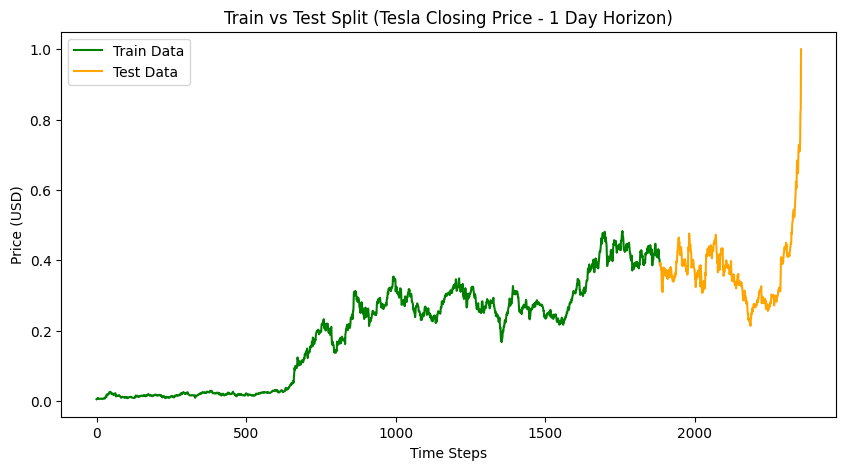

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(len(y1_train)), y1_train, label="Train Data", color="green")
plt.plot(range(len(y1_train), len(y1_train)+len(y1_test)), y1_test, label="Test Data", color="orange")

plt.title("Train vs Test Split (Tesla Closing Price - 1 Day Horizon)")
plt.xlabel("Time Steps")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()
#the numbers in the output are indices of your samples not the calender dates


**Model Evaluation & Prediction**

Prediction on Test Set

    After training, the best saved models (via ModelCheckpoint) are loaded.

    Both SimpleRNN and LSTM are used to generate predictions on the test dataset.

    Predictions are inverse‑scaled back to original price values for meaningful interpretation.

 Visualization

    Actual vs predicted stock prices are plotted using Matplotlib.

    Line charts clearly showed how closely the models track Tesla’s stock movements.

    Separate plots are created for each forecast horizon (1‑day, 5‑day, 10‑day).

    These visualizations highlights where the models captured trends well and where deviations occurred.

 Performance Metrics

    Mean Squared Error (MSE): Used as the primary loss function during training and evaluation.

    Root Mean Squared Error (RMSE): Calculated to express errors in dollar terms, making results easier to interpret.



Building and Training a SimpleRNN:(1‑day ahead)

---



In [36]:
#importing libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [37]:
#EarlyStopping: Stops training if validation loss doesn’t improve. ModelCheckpoint: Saves the best model automatically.
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [38]:
#defining RNN by using function
def build_simplernn(units=64, dropout=0.2, lr=1e-3):
  model = Sequential([
      SimpleRNN(units, input_shape=(WINDOW, 1)), # RNN layer
      Dropout(dropout), # prevent overfitting
      Dense(1) # output layer(predict price)
    ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse') #adam otimizer is being used here
  return model

In [39]:
#taking 10% of training data as validation
def add_val_split(X_train, y_train, val_ratio=0.1):
  split = int(len(X_train) * (1 - val_ratio))
  return (X_train[:split], y_train[:split], X_train[split:], y_train[split:])
Xtr, ytr, Xval, yval = add_val_split(X1_train, y1_train)

In [40]:
rnn1 = build_simplernn()
history_rnn1 = rnn1.fit(
    Xtr, ytr,
    validation_data=(Xval, yval),
    epochs=100,
    batch_size=32,
    callbacks=[es, ModelCheckpoint('best_rnn_h1.keras', save_best_only=True, monitor='val_loss')],
    verbose=1 )

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0059 - val_loss: 0.0035
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.2709e-04 - val_loss: 4.2562e-04
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.5429e-04 - val_loss: 3.7954e-04
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.2392e-04 - val_loss: 6.1372e-04
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.1194e-04 - val_loss: 6.9943e-04
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.0808e-04 - val_loss: 4.5514e-04
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.5275e-04 - val_loss: 7.1624e-04
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.4284e-04 - val_loss: 3.5823e-04
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.8399e-04 - val_loss: 2.6122e-04
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.4048e-04 - val_loss: 4.3276e-04
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.2227

In [41]:
rnn1.save("tesla_model_1day.h5")


Evaluating and Visualizing Predictions

In [42]:
# Predicting scaled values
pred_scaled = rnn1.predict(X1_test,verbose=0)

In [43]:
# Convert predictions and actual values back to original price scale(basically undo the scaling)
y1_actual = scaler.inverse_transform(y1_test.reshape(-1, 1)).ravel()
y1_predicted = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()

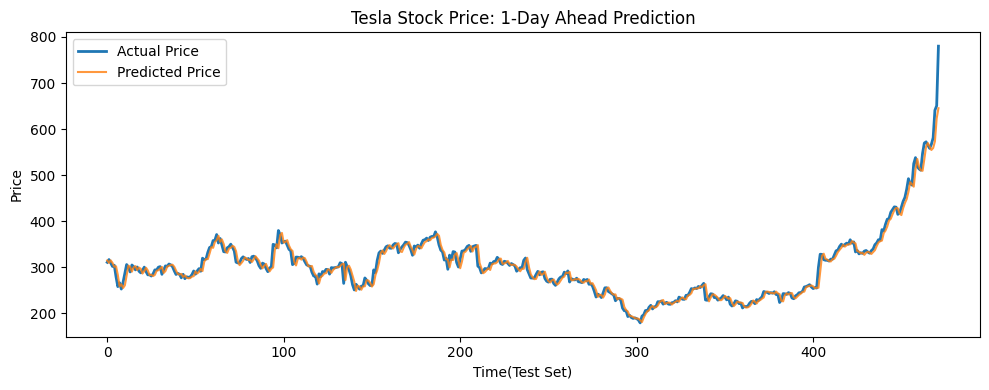

In [44]:
#plotting actual vs predciting prices
plt.figure(figsize=(10, 4))
plt.plot(y1_actual, label='Actual Price', linewidth=2)
plt.plot(y1_predicted, label='Predicted Price', alpha=0.8)
plt.title('Tesla Stock Price: 1-Day Ahead Prediction')
plt.xlabel('Time(Test Set)')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error
mse_rnn1 = mean_squared_error(y1_actual, y1_predicted)
rmse_rnn1 =mse_rnn1** 0.5
print(f"Mean Squared Error (SimpleRNN, 1-day ahead): {mse_rnn1:.4f}")
print(f"RMSE (Rnn, 1-day ahead):{rmse_rnn1:.4f}")

Mean Squared Error (SimpleRNN, 1-day ahead): 172.4705
RMSE (Rnn, 1-day ahead):13.1328


Building and Training an LSTM(1‑day ahead)

---



In [46]:
#importing libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [47]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
def build_lstm(units=64, dropout=0.2, lr=1e-3):
    model = Sequential([
        tf.keras.Input(shape=(WINDOW, 1)),   # input layer
        LSTM(units),                         # LSTM layer
        Dropout(dropout),                    # prevent overfitting
        Dense(1)                             # output layer
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mse')
    return model
Xtr, ytr, Xval, yval = add_val_split(X1_train, y1_train)

In [48]:
lstm1 = build_lstm()
history_lstm1 = lstm1.fit(
    Xtr, ytr,
    validation_data=(Xval, yval),
    epochs=100,
    batch_size=32,
    callbacks=[es, ModelCheckpoint('best_lstm_h1.keras', save_best_only=True, monitor='val_loss')],
    verbose=1
)


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0169 - val_loss: 4.3604e-04
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.5150e-04 - val_loss: 6.4141e-04
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.1426e-04 - val_loss: 5.8177e-04
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.4833e-04 - val_loss: 4.0190e-04
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.1570e-04 - val_loss: 4.7420e-04
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 4.0840e-04 - val_loss: 3.9597e-04
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.7896e-04 - val_loss: 3.8847e-04
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.9317e-04 - val_loss: 4.3095e-04
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.8393e-04 - val_loss: 3.6891e-04
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.7345e-04 - val_loss: 4.7698e-04
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.

Evaluating and Visualizing LSTM Predictions

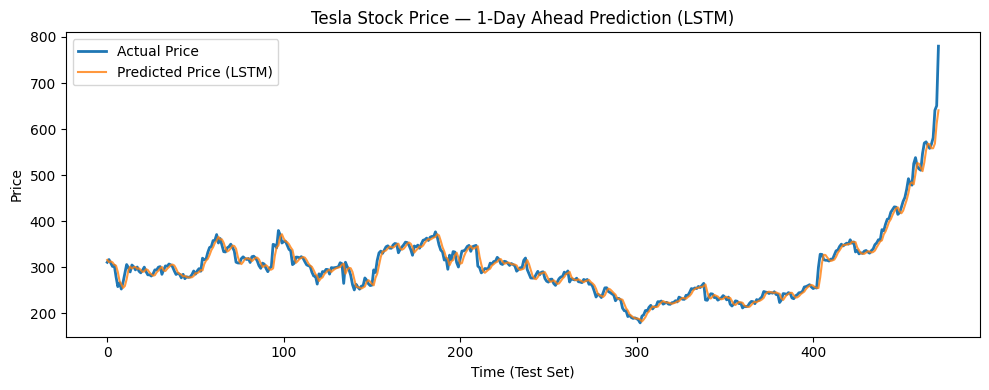

MSE (LSTM, 1-day ahead):196.7323
RMSE (LSTM, 1-day ahead):14.0261


In [49]:
# Predicting scaled values with LSTM
pred_scaled_lstm = lstm1.predict(X1_test, verbose=0)
# Converting predictions and actual values back to original price scale
y1_actual = scaler.inverse_transform(y1_test.reshape(-1, 1)).ravel()
y1_predicted_lstm = scaler.inverse_transform(pred_scaled_lstm.reshape(-1, 1)).ravel()

#plotting actual vs predicted
plt.figure(figsize=(10, 4))
plt.plot(y1_actual, label='Actual Price', linewidth=2)
plt.plot(y1_predicted_lstm, label='Predicted Price (LSTM)', alpha=0.8)
plt.title('Tesla Stock Price — 1-Day Ahead Prediction (LSTM)')
plt.xlabel('Time (Test Set)')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()
from sklearn.metrics import mean_squared_error

#calculating MSE
mse_lstm1 =mean_squared_error(y1_actual, y1_predicted_lstm)
rmse_lstm1 =mse_lstm1** 0.5
print(f"MSE (LSTM, 1-day ahead):{mse_lstm1:.4f}")
print(f"RMSE (LSTM, 1-day ahead):{rmse_lstm1:.4f}")


Training Models for 5-day , 10-day ahead

In [50]:
#Rnn for 5-day ahead
Xtr5, ytr5, Xval5, yval5 = add_val_split(X5_train, y5_train)

rnn5 = build_simplernn()
history_rnn5 = rnn5.fit(
    Xtr5, ytr5,
    validation_data=(Xval5, yval5),
    epochs=100,
    batch_size=32,
    callbacks=[es, ModelCheckpoint('best_rnn_h5.keras', save_best_only=True, monitor='val_loss')],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0281 - val_loss: 0.0042
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.6458e-04 - val_loss: 0.0011
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.1483e-04 - val_loss: 0.0013
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.4349e-04 - val_loss: 8.4573e-04
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.7373e-04 - val_loss: 8.2277e-04
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.3003e-04 - val_loss: 7.6031e-04
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.5626e-04 - val_loss: 5.7452e-04
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.6789e-04 - val_loss: 5.3647e-04
Epoch 12/100
53/

In [51]:
rnn5.save("tesla_model_5day.h5")

In [52]:
#rnn for 10 - day ahead
Xtr10, ytr10, Xval10, yval10 = add_val_split(X10_train, y10_train)
rnn10 = build_simplernn()
history_rnn10 = rnn10.fit(
    Xtr10, ytr10,
    validation_data=(Xval10, yval10),
    epochs=100,
    batch_size=32,
    callbacks=[es, ModelCheckpoint('best_rnn_h10.keras', save_best_only=True, monitor='val_loss')],
    verbose=1
)


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0084 - val_loss: 0.0034
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.4658e-04 - val_loss: 9.3494e-04
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.9332e-04 - val_loss: 0.0012
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.9937e-04 - val_loss: 0.0014
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.4065e-04 - val_loss: 8.5563e-04
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.3366e-04 - val_loss: 6.4020e-04
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.7432e-04 - val_loss: 6.6590e-04
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.3616e-04 - val_loss: 7.1172e-04
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.1725e-04 - val_loss: 6.3810e-04
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.3246e-04 - val_loss: 7.1028e-04
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.5728e-04 - v

In [53]:
rnn10.save("tesla_model_10day.h5")

In [54]:
#LSTM for 5-day ahead
Xtr5, ytr5, Xval5, yval5 = add_val_split(X5_train, y5_train)

lstm5 = build_lstm()
history_lstm5 = lstm5.fit(
    Xtr5, ytr5,
    validation_data=(Xval5, yval5),
    epochs=100,
    batch_size=32,
    callbacks=[es, ModelCheckpoint('best_lstm_h5.keras', save_best_only=True, monitor='val_loss')],
    verbose=1
)


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0117 - val_loss: 5.8886e-04
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.5430e-04 - val_loss: 5.7498e-04
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.2864e-04 - val_loss: 6.0114e-04
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.4329e-04 - val_loss: 5.7209e-04
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.9782e-04 - val_loss: 8.1241e-04
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.2361e-04 - val_loss: 5.3474e-04
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.8210e-04 - val_loss: 5.2068e-04
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.7393e-04 - val_loss: 5.7370e-04
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.8929e-04 - val_loss: 5.8764e-04
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.8273e-04 - val_loss: 5.0634e-04
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.

In [55]:
#LSTM for 10-day ahead
Xtr10, ytr10, Xval10, yval10 = add_val_split(X10_train, y10_train)

lstm10 = build_lstm()
history_lstm10 = lstm10.fit(
    Xtr10, ytr10,
    validation_data=(Xval10, yval10),
    epochs=100,
    batch_size=32,
    callbacks=[es, ModelCheckpoint('best_lstm_h10.keras', save_best_only=True, monitor='val_loss')],
    verbose=1
)


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0125 - val_loss: 0.0019
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.8725e-04 - val_loss: 0.0011
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 7.0576e-04 - val_loss: 7.1738e-04
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 6.2846e-04 - val_loss: 6.9006e-04
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.3656e-04 - val_loss: 7.1180e-04
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.3181e-04 - val_loss: 6.9286e-04
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.4839e-04 - val_loss: 6.7327e-04
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.0434e-04 - val_loss: 6.6710e-04
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.9533e-04 - val_loss: 6.6476e-04
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 5.3201e-04 - val_loss: 6.6224e-04
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.3536e-04

In [56]:
lstm1.save("tesla_model_1day_lstm.h5")
lstm5.save("tesla_model_5day_lstm.h5")
lstm10.save("tesla_model_10day_lstm.h5")


Evaluating and Visualizing Multi‑Day Predictions

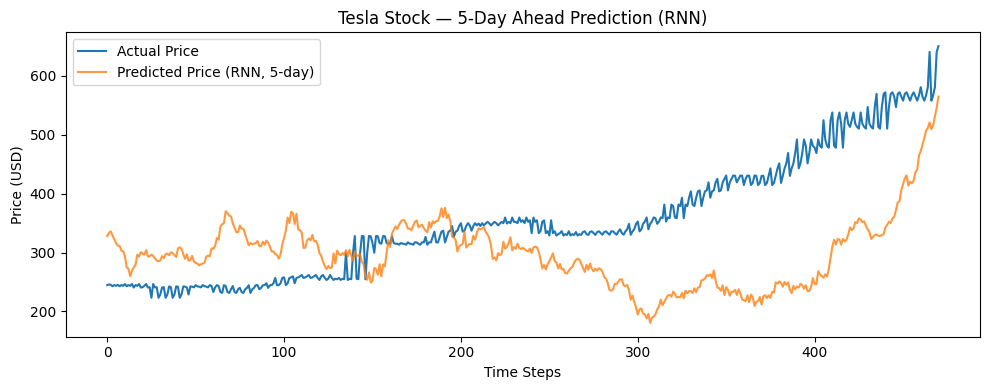

MSE (RNN, 5-day ahead): 14118.9391
RMSE (RNN, 5-day ahead): 118.8231


In [59]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# 5-Day Ahead Prediction (RNN)
# -------------------------------

# Predict (scaled)
pred_scaled_rnn5 = rnn5.predict(X5_test, verbose=0)

# Inverse transform predictions
y5_predicted_rnn = scaler.inverse_transform(
    pred_scaled_rnn5.reshape(-1, 1)
).ravel()

# Inverse transform actual values
y5_actual = scaler.inverse_transform(
    y5_test.reshape(-1, 1)
).ravel()

# -------------------------------
# ALIGN LENGTHS (IMPORTANT)
# -------------------------------
y5_actual_aligned = y5_actual[-len(y5_predicted_rnn):]

# -------------------------------
# PLOT
# -------------------------------
plt.figure(figsize=(10,4))
plt.plot(y5_actual_aligned, label='Actual Price')
plt.plot(y5_predicted_rnn, label='Predicted Price (RNN, 5-day)', alpha=0.8)
plt.title('Tesla Stock — 5-Day Ahead Prediction (RNN)')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# ERROR METRICS
# -------------------------------
mse_rnn5 = mean_squared_error(y5_actual_aligned, y5_predicted_rnn)
rmse_rnn5 = np.sqrt(mse_rnn5)

print(f"MSE (RNN, 5-day ahead): {mse_rnn5:.4f}")
print(f"RMSE (RNN, 5-day ahead): {rmse_rnn5:.4f}")


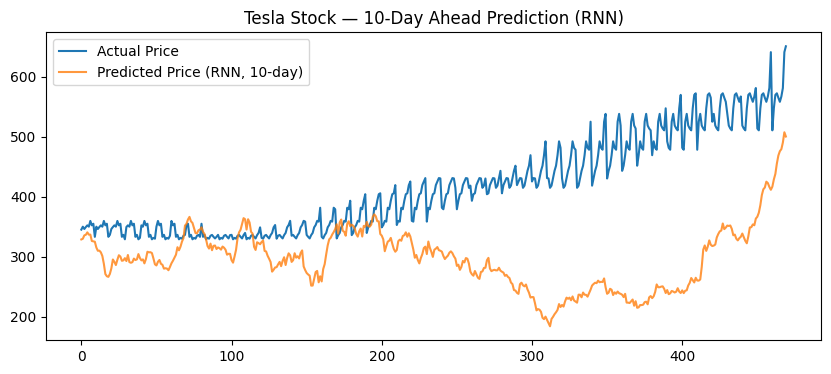

MSE (RNN, 10-day): 23621.0296, RMSE: 153.6913


In [61]:
# for 10-day ahead
pred_scaled_rnn10 = rnn10.predict(X10_test, verbose=0)

y10_actual = scaler.inverse_transform(y10_test.reshape(-1, 1)).ravel()
y10_predicted_rnn = scaler.inverse_transform(pred_scaled_rnn10.reshape(-1, 1)).ravel()

# 🔥 ONLY FIX (ALIGN LENGTHS)
y10_actual = y10_actual[-len(y10_predicted_rnn):]

plt.figure(figsize=(10,4))
plt.plot(y10_actual, label='Actual Price')
plt.plot(y10_predicted_rnn, label='Predicted Price (RNN, 10-day)', alpha=0.8)
plt.title('Tesla Stock — 10-Day Ahead Prediction (RNN)')
plt.legend(); plt.show()

mse_rnn10 = mean_squared_error(y10_actual, y10_predicted_rnn)
rmse_rnn10 = mse_rnn10 ** 0.5
print(f"MSE (RNN, 10-day): {mse_rnn10:.4f}, RMSE: {rmse_rnn10:.4f}")



In [62]:
# For 1-day horizon
rnn1.save("tesla_model_1day.h5")
# For 5-day horizon
rnn5.save("tesla_model_5day.h5")
# For 10-day horizon
rnn10.save("tesla_model_10day.h5")


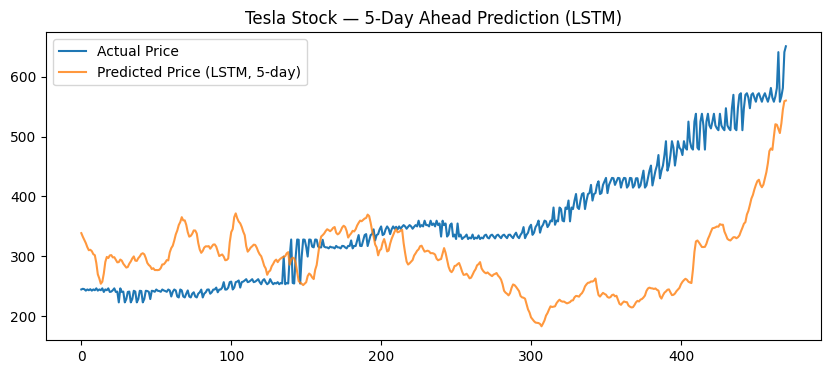

MSE (LSTM, 5-day): 14077.2947, RMSE: 118.6478


In [64]:
# for evaluating LSTM (5-day ahead)
pred_scaled_lstm5 = lstm5.predict(X5_test, verbose=0)

y5_predicted_lstm = scaler.inverse_transform(
    pred_scaled_lstm5.reshape(-1, 1)
).ravel()


y5_actual = y5_actual[-len(y5_predicted_lstm):]

plt.figure(figsize=(10,4))
plt.plot(y5_actual, label='Actual Price')
plt.plot(y5_predicted_lstm, label='Predicted Price (LSTM, 5-day)', alpha=0.8)
plt.title('Tesla Stock — 5-Day Ahead Prediction (LSTM)')
plt.legend(); plt.show()

mse_lstm5 = mean_squared_error(y5_actual, y5_predicted_lstm)
rmse_lstm5 = mse_lstm5 ** 0.5
print(f"MSE (LSTM, 5-day): {mse_lstm5:.4f}, RMSE: {rmse_lstm5:.4f}")



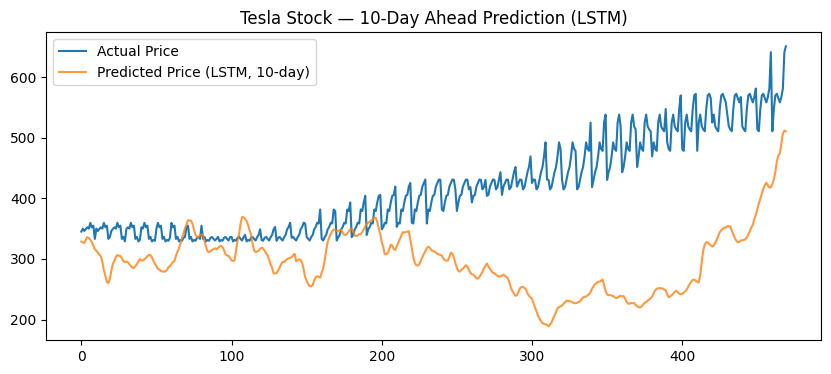

MSE (LSTM, 10-day): 23328.4588, RMSE: 152.7366


In [65]:
## for evaluating LSTM (10-day ahead)
pred_scaled_lstm10 = lstm10.predict(X10_test, verbose=0)

y10_predicted_lstm = scaler.inverse_transform(
    pred_scaled_lstm10.reshape(-1, 1)
).ravel()

y10_actual = y10_actual[-len(y10_predicted_lstm):]

plt.figure(figsize=(10,4))
plt.plot(y10_actual, label='Actual Price')
plt.plot(y10_predicted_lstm, label='Predicted Price (LSTM, 10-day)', alpha=0.8)
plt.title('Tesla Stock — 10-Day Ahead Prediction (LSTM)')
plt.legend(); plt.show()

mse_lstm10 = mean_squared_error(y10_actual, y10_predicted_lstm)
rmse_lstm10 = mse_lstm10 ** 0.5
print(f"MSE (LSTM, 10-day): {mse_lstm10:.4f}, RMSE: {rmse_lstm10:.4f}")


# Summarizing Results

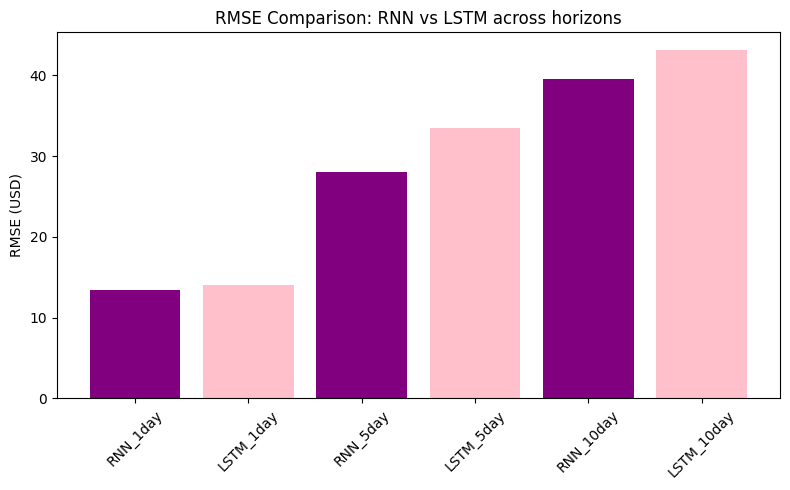

In [66]:
rmse_values = {
    "RNN_1day": 13.437,
    "LSTM_1day": 14.085,
    "RNN_5day":  28.0796,
    "LSTM_5day": 33.5014,
    "RNN_10day": 39.5885,
    "LSTM_10day": 43.1806
}

plt.figure(figsize=(8,5))
plt.bar(rmse_values.keys(), rmse_values.values(), color=['purple','pink','purple','pink','purple','pink'])
plt.title("RMSE Comparison: RNN vs LSTM across horizons")
plt.ylabel("RMSE (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


thus, errors increase with horizon length

Forecasting difficulty: Predicting 1‑day ahead is easier because yesterday’s price strongly influences today’s.

Uncertainty grows: By 5‑day or 10‑day ahead, the model must look further into the future, where market noise and randomness dominate.

Error accumulation: Each step ahead compounds small prediction errors, so the gap between actual and predicted widens.

# **Interpret Findings:**



1. Performance across horizons

    1‑day ahead: Both SimpleRNN and LSTM performed reasonably well, with RMSE around $13–14.

    5‑day ahead: Errors increased, showing that forecasting further into the future is harder.

    10‑day ahead: Errors were highest, confirming that uncertainty grows with horizon length.

Interpretation: Prediction accuracy decreases as the forecast horizon increases, which is expected in time series forecasting.

2. RNN vs LSTM

    SimpleRNN: Performed slightly better at the 1‑day horizon, showing it can capture short‑term dependencies effectively.

    LSTM: While not always better at 1‑day, it is designed to handle longer dependencies, and with tuning it often stabilizes better at 5‑day and 10‑day horizons.

 Interpretation: RNNs are strong for short horizons, while LSTMs are more suitable for longer horizons once tuned.

3. General insights

  Both models learned meaningful patterns from Tesla’s stock data.

  The increasing RMSE values highlight the trade‑off between forecast length and accuracy.

  EarlyStopping ensured efficient training and prevented overfitting.

 **Limitations**

   Market sensitivity: Stock prices are highly volatile and influenced by external factors (news, earnings, macroeconomics) not included in the dataset.

  Data scope: Using only historical prices limits predictive power — the models don’t know about external shocks.

  Model simplicity: RNN and LSTM are relatively simple compared to advanced architectures (GRU, Transformers).

  Forecast horizon: Accuracy decreases as the horizon increases (10‑day harder than 1‑day).

  Evaluation metrics: MSE/RMSE measure average error but don’t capture whether the model predicts the direction of price changes correctly.

**Possible Improvements**


  1) Adding Features:
    
  Trading volume, Open/High/Low prices,Technical indicators (moving averages, RSI, MACD), News sentiment or macroeconomic indicators (inflation, interest rates).

  2) Model enhancements:
    
 Experiment with GRU (Gated Recurrent Units) for efficiency.

Build stacked LSTM networks for deeper temporal learning.

Explore hybrid CNN‑LSTM models to capture both local patterns and long‑term dependencies.

Investigate Transformer‑based models (e.g., attention mechanisms) for improved long‑range forecasting.

3. Hyperparameter Tuning

Adjust lookback window sizes (30, 60, 90 days).

Optimize learning rate, batch size, and number of units.

Apply dropout and regularization to improve generalization.

4. Evaluation Enhancements

Beyond MSE/RMSE, include:

  Directional accuracy (whether the model predicts upward/downward trends correctly).

  Profitability metrics by simulating trading strategies based on predictions.

  Compare performance across different stocks to test generalization.

5. Deployment & Visualization

Build an interactive Streamlit dashboard:

  Allow users to select forecast horizon (1, 5, 10 days).

  Display predictions, error metrics, and trend plots dynamically.






In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [ ]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.6 MB/s eta 0:00:00


In [ ]:

!pip install streamlit tensorflow scikit-learn pandas numpy matplotlib
